In [6]:
import numpy as np
import rasterio 

from rasterio.warp import calculate_default_transform, reproject, resampling
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt 
import os

In [9]:
#Load geojson file and convert to crs
gdf = gpd.read_file('./Isla_Vista_Kelp.geojson')


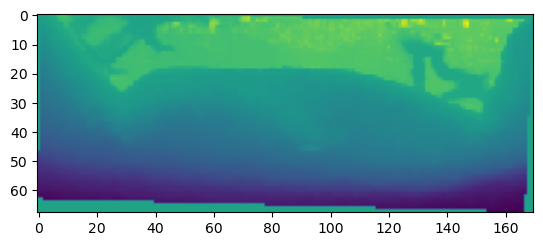

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 170, 'height': 68, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777790359107088, 0.0, -119.8863856284374,
       0.0, -0.0002777790359107086, 34.414445985118086)}


In [13]:
#Load DEM 
map_path = './maps/'
dem_name = 'sb_DEM.tiff'

dem_path = os.path.join(map_path,dem_name)
with rasterio.open(dem_path) as dem_src:
    if dem_src != gdf.crs:
        gdf=gdf.to_crs(dem_src.crs)

geometry = [geom for geom in gdf.geometry]

with rasterio.open(dem_path) as dem_src:
    dem, dem_transform = mask(dem_src,geometry, crop = True)
    dem_meta = dem_src.meta.copy()


dem_meta.update({
    "driver": "GTiff",
    "height": dem.shape[1],
    "width": dem.shape[2],
    "transform": dem_transform
})

show(dem)
print(dem_meta)

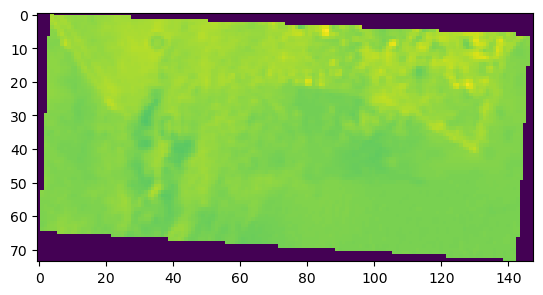

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 148, 'height': 74, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 234630.0,
       0.0, -30.0, 3811890.0)}


In [12]:
tif_name = 'HLS.L30.T11SKU.2020144T183333.v2.0.B01.tif'


geotiff_path = os.path.join('./imagery/', tif_name)
with rasterio.open(geotiff_path) as geotiff_src:
    if geotiff_src != gdf.crs:
        gdf=gdf.to_crs(geotiff_src.crs)

geometry = [geom for geom in gdf.geometry]

with rasterio.open(geotiff_path) as geotiff_src:
    geotiff, geotiff_transform = mask(geotiff_src,geometry, crop = True)
    geotiff_meta = geotiff_src.meta.copy()

geotiff_meta.update({
    "driver": "GTiff",
    "height": geotiff.shape[1],
    "width": geotiff.shape[2],
    "transform": geotiff_transform
})

show(geotiff)
print(geotiff_meta)

In [ ]:
help(calculate_default_transform)

In [ ]:
help(raster.crop)

In [15]:
#Convert DEM size 
print(dem_meta)
print(geotiff_meta['crs'])
if dem_meta['crs'] != geotiff_meta['crs'] or dem.shape != geotiff.shape: #Check for != resolution/framing
    transform, width, height = calculate_default_transform(
        dem_meta['crs'], geotiff_meta['crs'], dem_meta['width'], dem_meta['height'], *dem_src.bounds)
    dem_resampled = np.empty((height, width), dtype=np.float32) #Create empty DEM 
    print (transform)
    reproject(
        source=dem,
        destination=dem_resampled,
        src_transform=dem_meta['transform'],
        src_crs=dem_meta['crs'], #Reproject with tiff_CRS = dem_CRS
        dst_transform=geotiff_meta['transform'],
        dst_crs=geotiff_meta['crs'],
        resampling=Resampling.bilinear)
    dem = dem_resampled
    print(width)
    print(height)
    dem_meta.update({
        'crs': geotiff_meta['crs'],
        'transform': transform,
        'width': width,
        'height': height
    })
    print (dem_meta)
    print (geotiff_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 135, 'height': 131, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(1495.06387889515, 0.0, 145035.48920086492,
       0.0, -1495.06387889515, 3885858.516741325)}
EPSG:32611
| 0.01, 0.00,-120.81|
| 0.00,-0.01, 35.06|
| 0.00, 0.00, 1.00|
146
118
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 146, 'height': 118, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(0.01455042141889023, 0.0, -120.81333427127143,
       0.0, -0.01455042141889023, 35.05556)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 148, 'height': 74, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 234630.0,
       0.0, -30.0, 3811890.0)}


In [ ]:
print(dem)

In [ ]:
#mask = (dem <= 0)# & (dem >= -100)
geotiff_masked = np.where(dem, geotiff, np.nan)

In [ ]:
plt.imshow(mask)